[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marceloprates/Floral-Automata-Jupyter/blob/master/Floral Automata.ipynb)

# Functions to encode, decode and run cellular automata

In [1]:
import numpy as np

# Functions to encode / decode a cellular automaton rule
# into / from an integer (respectively), using the Wolfram convention
def encode_rule(rule, S, K):
    code = int(sum([(S**k)*rule[k] for k in range(S**K)]))
    return code

def decode_rule(code, S, K):
    rule = np.zeros(S**K, dtype=np.int)
    i = S**K-1
    while code > 0:
        rule[i] = code % S
        code = code // S
        i -= 1
    return rule[::-1]

# Function to run a cellular automaton rule given an initial
# N-sized tape. Returns a 'steps' x 'N' matrix
def run_cellauto(S, K, rule, steps, tape):
    N = tape.shape[0]
    tapes = np.zeros((steps, N))
    tapes[0, :] = tape
    for i in range(steps-1):
        for j in range(N):
            idx = int(sum([S**(K-(k+K//2)-1)*tapes[i, (j+k)%N] for k in range(-(K//2), K//2+1)]))
            tapes[(i+1)%N, j] = rule[idx]
    return tapes

# Function to initialize the CA tape
def init_tape(N=128, petals=8):
    tape = np.zeros(N)
    tape[[i for i in range(len(tape)) if i%(N//petals)==0]] = 1
    return tape

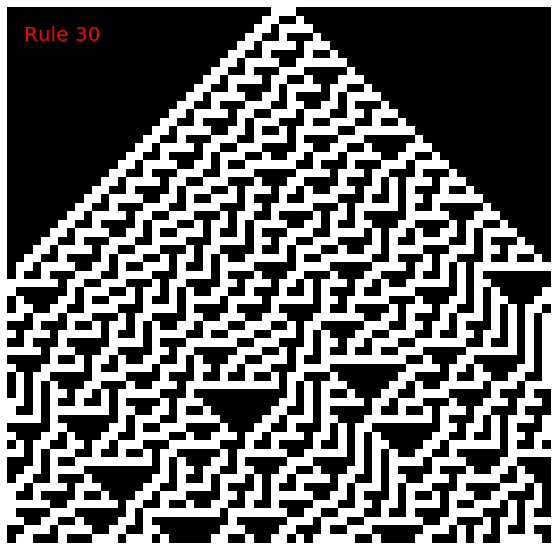

In [53]:
from matplotlib import cm
from matplotlib import patches

N, S, K, steps, code = 64, 2, 3, 64, 30
tape = np.zeros(N)
tape[N//2] = 1
tapes = run_cellauto(S, K, decode_rule(code, S, K), steps, tape)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0,steps)
ax.set_ylim(0,N)
plt.axis('off')
ax.set_aspect('equal')
for i in range(steps):
    for j in range(N):
        ax.add_patch(patches.Rectangle((j, steps-i), 1, 1, color='white' if tapes[i, j] else 'black'))
ax.text(2, steps - 4, f'Rule {code}', color='red', fontsize=20)
plt.show()

# Functions to visualize cellauto rules

In [35]:
import numpy as np
from matplotlib import cm
from matplotlib import patches
from matplotlib import pyplot as plt

def visualize_rule(rule, S, K, grid=False):
    n_configs = S**K
    sqrt_n_configs = int(np.ceil(np.sqrt(n_configs)))
    
    if grid:
        fig, ax = plt.subplots(figsize=(sqrt_n_configs*(K+1), sqrt_n_configs*3))
    else:
        fig, ax = plt.subplots(figsize=(n_configs*(K+1), 2))
    
    plt.axis('off')
    ax.set_aspect('equal')
    
    if grid:
        ax.set_xlim(-S//2-1,sqrt_n_configs*(K+1))
        ax.set_ylim(-1,sqrt_n_configs*3)
    else:
        ax.set_xlim(-S//2-1,n_configs*(K+1))
        ax.set_ylim(-1,2)
    
    colors = cm.Pastel1(np.linspace(0,1,S))
    
    config_i = 0
    config = [(config_i//(S**k))%S for k in range(K)]
    for i in range(sqrt_n_configs if grid else n_configs):
        for j in range(sqrt_n_configs if grid else 1):
            if grid:
                xy = np.array((j*(K+1), (sqrt_n_configs-i-1)*3))
            else:
                xy = np.array(((n_configs-i-1)*(K+1), 0))
            
            ax.add_patch(patches.Rectangle(
                xy, 1, 1,
                color=colors[rule[config_i]], fill=True
            ))
            ax.add_patch(patches.Rectangle(
                xy, 1, 1,
                color='black', fill=False
            ))
            
            for k in range(K):
                ax.add_patch(patches.Rectangle(
                    xy + np.array((k-K//2,1)), 1, 1,
                    color=colors[config[k]], fill=True
                ))
                ax.add_patch(patches.Rectangle(
                    xy + np.array((k-K//2,1)), 1, 1,
                    color='black', fill=False
                ))
            
            config_i += 1
            config = [(config_i//(S**k))%S for k in range(K)][::-1]
            if config_i >= n_configs:
                return fig, ax

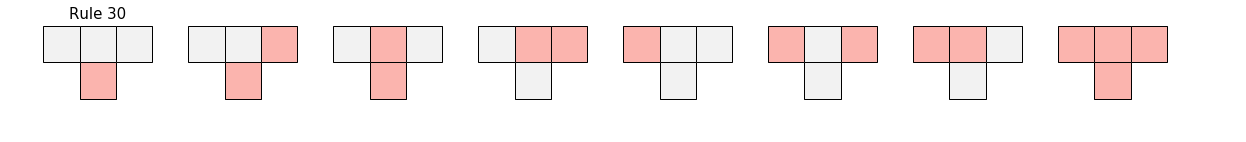

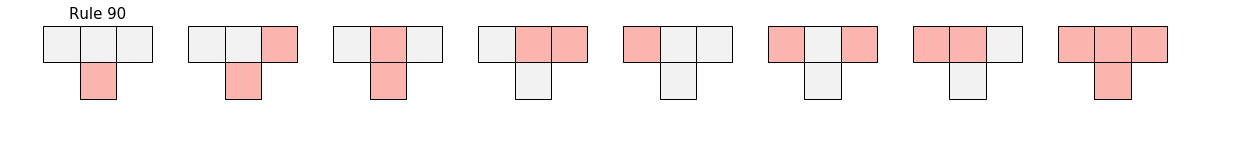

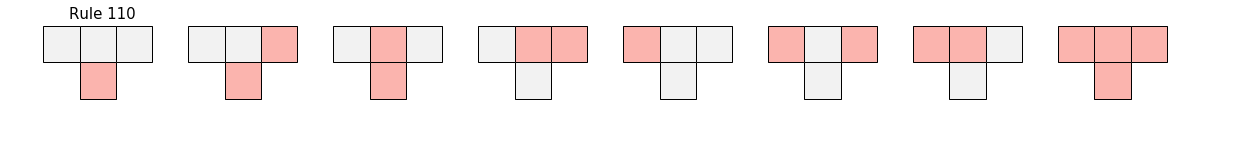

In [36]:
for code in [30, 90, 110]: 
    fig, ax = visualize_rule(decode_rule(30, 2, 3), 2, 3, grid=False)
    ax.text(-.3, 2.2, f'Rule {code}', c='black', fontsize=15)
    plt.show()

# Functions to draw Floral Automata

In [75]:
import cv2
import numpy as np
from math import sin, cos
from scipy import ndimage
from matplotlib import cm
from matplotlib import patches
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Function to draw a circle arc
def draw_arc(ax, center, theta1, theta2, radius1, radius2, **kwargs):
    N = 20
    poly = np.zeros((2*N, 2))
    for i, theta in enumerate(np.linspace(theta1, theta2, N)):
        poly[i, :] = radius1*np.array([cos(theta), sin(theta)])
    for i, theta in enumerate(np.linspace(theta2, theta1, N)):
        poly[N + i, :] = radius2*np.array([cos(theta), sin(theta)])

    poly = patches.Polygon(np.array(poly), **kwargs)
    ax.add_patch(poly)

    return ax

# Function to quantize the colors of an image into 'n' bins
def quantize_colors(img, n, colors=None):
    if colors:
        img = img[:, :, 0]
        quantiz = np.array([mcolors.to_rgb(c) for c in colors])
    else:
        quantiz = np.int0(np.linspace(0,1,n))
        
    indices = np.arange(0,256)
    divider = np.linspace(0,255,n+1)[1]
    color_levels = np.clip(np.int0(indices/divider),0,n-1)
    palette = quantiz[color_levels]
    img = palette[img]
    
    return img

# Function to draw a floral automaton given a rule and an initial tape
def floral_automaton(
    S,
    K,
    rule,
    tape,
    blur=10,
    steps=20,
    descending=True,
    n_colors=2,
    colors=None,
    figsize=(20, 20)):
    
    # Run cellular automaton
    tapes = run_cellauto(S, K, rule, steps, tape)
    
    # Init canvas in which we will draw circular arcs
    fig, ax = plt.subplots(figsize=figsize)
    canvas = FigureCanvas(fig)
    plt.tight_layout()
    ax.axis('off')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_aspect('equal')

    # Draw circular arcs
    N, M = tapes.shape
    for i in range(N):
        for j in range(M):
            # Get color
            c = tapes[i if descending else N-i-1, j] * np.ones(3) / (S-1)
            draw_arc(
                ax, (0, 0),
                2*np.pi*(j)/M, 2*np.pi*(j+1)/M,
                (N-i-1)/N, (N-i)/N,
                fc = c, ec = c
            )
            
    # Draw on canvas and close figure
    canvas.draw()
    s, (w, h) = canvas.print_to_buffer()
    plt.close(fig)

    # Fetch the image pixels from the canvas
    img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(h, w, 3)
    # Blur the image
    img = ndimage.gaussian_filter(img, sigma=blur)
    # Quantize colors
    if colors:
        img = quantize_colors(img, len(colors), colors)
    else:
        img = quantize_colors(img, n_colors)
    
    # Make everything outside the inscribed circle transparent
    img = np.dstack((img, np.ones(img.shape[:-1])))
    for i in range(h):
        for j in range(w):
            if (i-w//2)**2 + (j-h//2)**2 > (w/2)**2:
                img[i, j, -1] = 0
    
    return img

# Demonstrations

## Draw 16 random floral automata

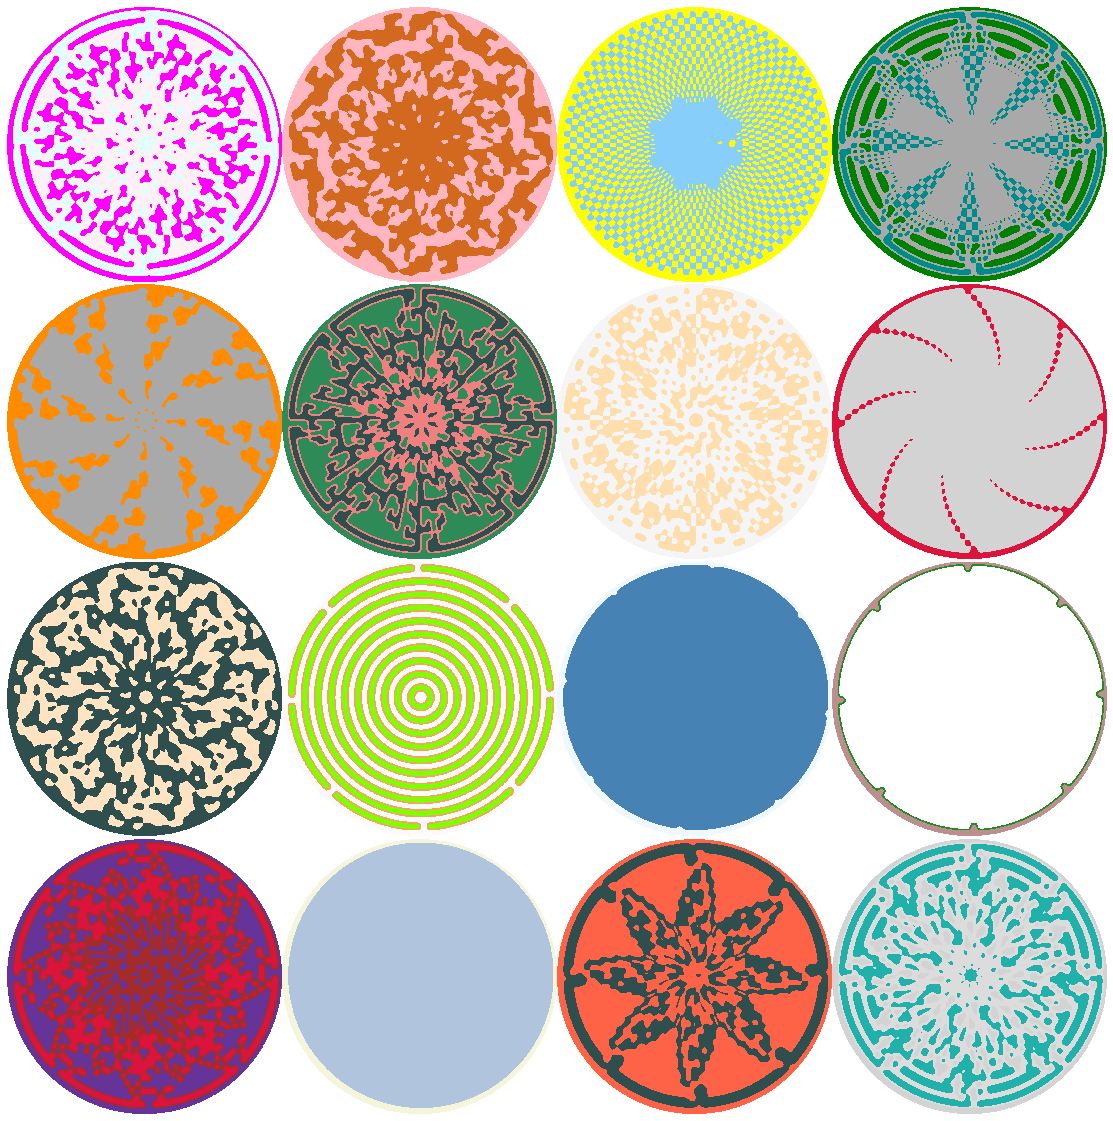

In [93]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
plt.axis('off')
plt.tight_layout()

N, steps = 128, 20
for i in range(16):
    
    S = np.random.choice([2,3])
    K = np.random.choice([3,5])
    descending = np.random.choice([True,False])
    n_colors = np.random.choice([2,3])
    colors = np.random.choice(list(mcolors.CSS4_COLORS.values()), n_colors, replace=False).tolist()
    
    tape = init_tape(N=N, petals=8)
    rule = np.random.choice(S, S**K)
    
    img = floral_automaton(
        S,
        K,
        rule,
        tape,
        steps=steps,
        colors=colors,
        descending=descending
    )
    
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Interactive generation

In [73]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, IntText, ToggleButton

def show_floral_automaton(S, K, N, steps, n_colors, descending, code, random_rule):
    tape = init_tape(N=N, petals=8)
    if random_rule:
        rule = np.random.choice(S, S**K)
    else:
        rule = decode_rule(code, S, K)
    colors = np.random.choice(list(mcolors.CSS4_COLORS.values()), n_colors, replace=False).tolist()
    img = floral_automaton(
        S,
        K,
        rule,
        tape,
        steps=steps,
        colors=colors, 
        descending=descending
    )
    plt.subplots(figsize=(10, 10))
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
interact_manual(
    show_floral_automaton,
    S = IntSlider(min=2, max=5, step=1, value=2),
    K = IntSlider(min=3, max=7, step=2, value=3),
    N = IntSlider(min=8, max=256, step=2, value=128),
    steps = IntSlider(min=10, max=100, step=5, value=20),
    n_colors = IntSlider(min=2, max=5, step=1, value=2),
    descending = IntSlider(min=0, max=1, step=1, value=0),
    code = IntText(min=0, step=1, value=30),
    random_rule = ToggleButton(),
);

interactive(children=(IntSlider(value=2, description='S', max=5, min=2), IntSlider(value=3, description='K', m…